In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv


In [6]:
twitter_data=pd.read_csv("/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv")
twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [8]:
twitter_data.shape

(162980, 2)

In [9]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [10]:
twitter_data['category'].value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [15]:
labels = pd.get_dummies(twitter_data.category)
labels.columns = ["negative", "neutral", "positive"]
labels.head()

,negative,neutral,positive
0,True,False,False
1,False,True,False
2,False,False,True
3,False,False,True
4,False,False,True


<Axes: xlabel='category', ylabel='count'>

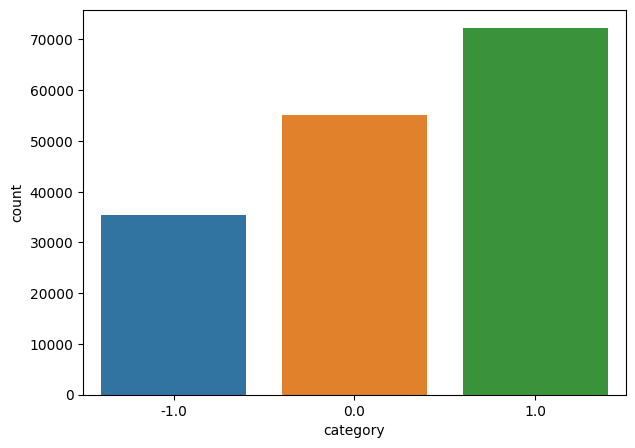

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(7,5))
sns.countplot(x="category",data=twitter_data)

Text(0.5, 1.0, 'Distribution of sentiments')

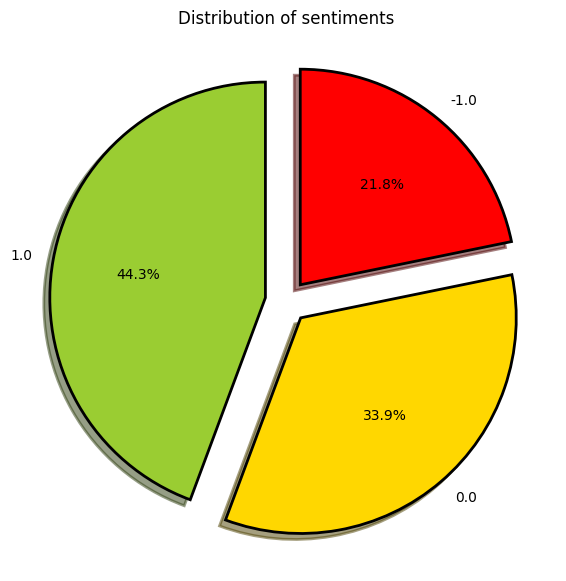

In [20]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = twitter_data['category'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

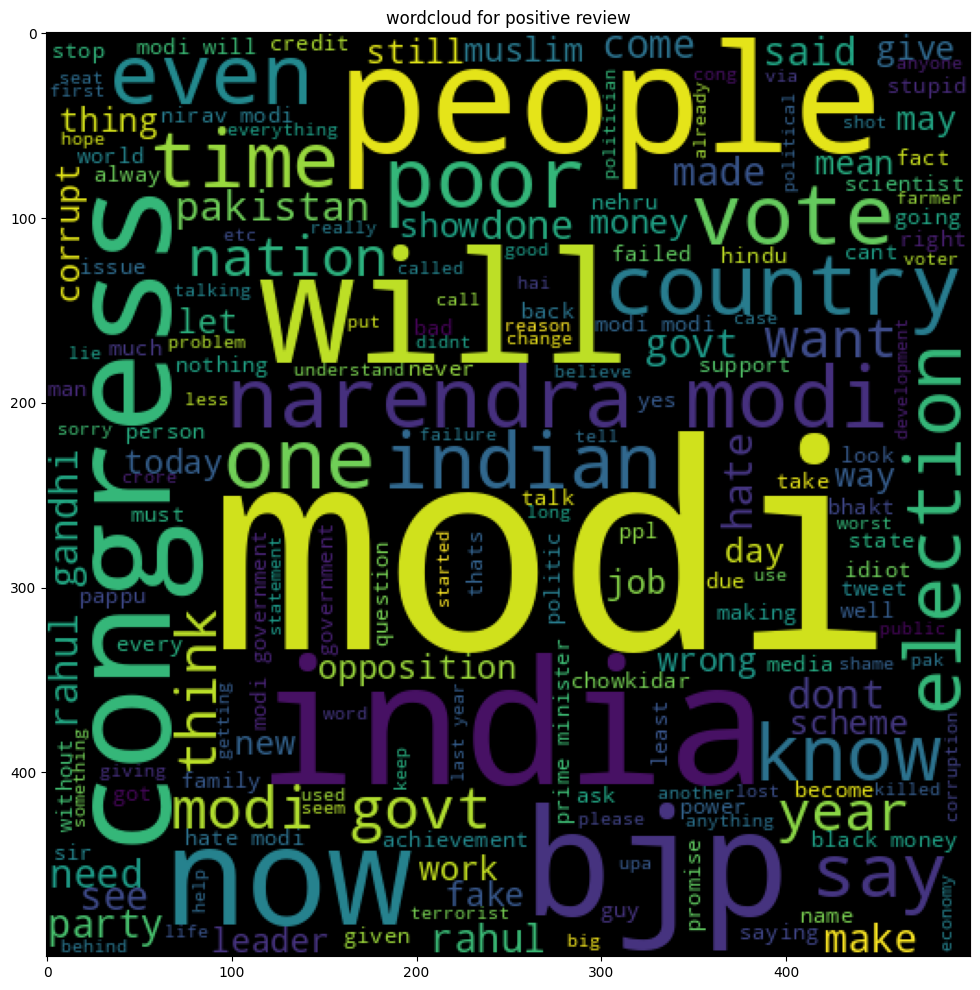

In [32]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
positive_wc = wc.generate(twitter_data[twitter_data['category'] == 1.0]['clean_text'].str.cat(sep = " "))
neutral_wc = wc.generate(twitter_data[twitter_data['category'] == 0.0]['clean_text'].str.cat(sep = " "))
negative_wc = wc.generate(twitter_data[twitter_data['category'] == -1.0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (12, 12))
plt.title('wordcloud for positive review')
plt.imshow(positive_wc)

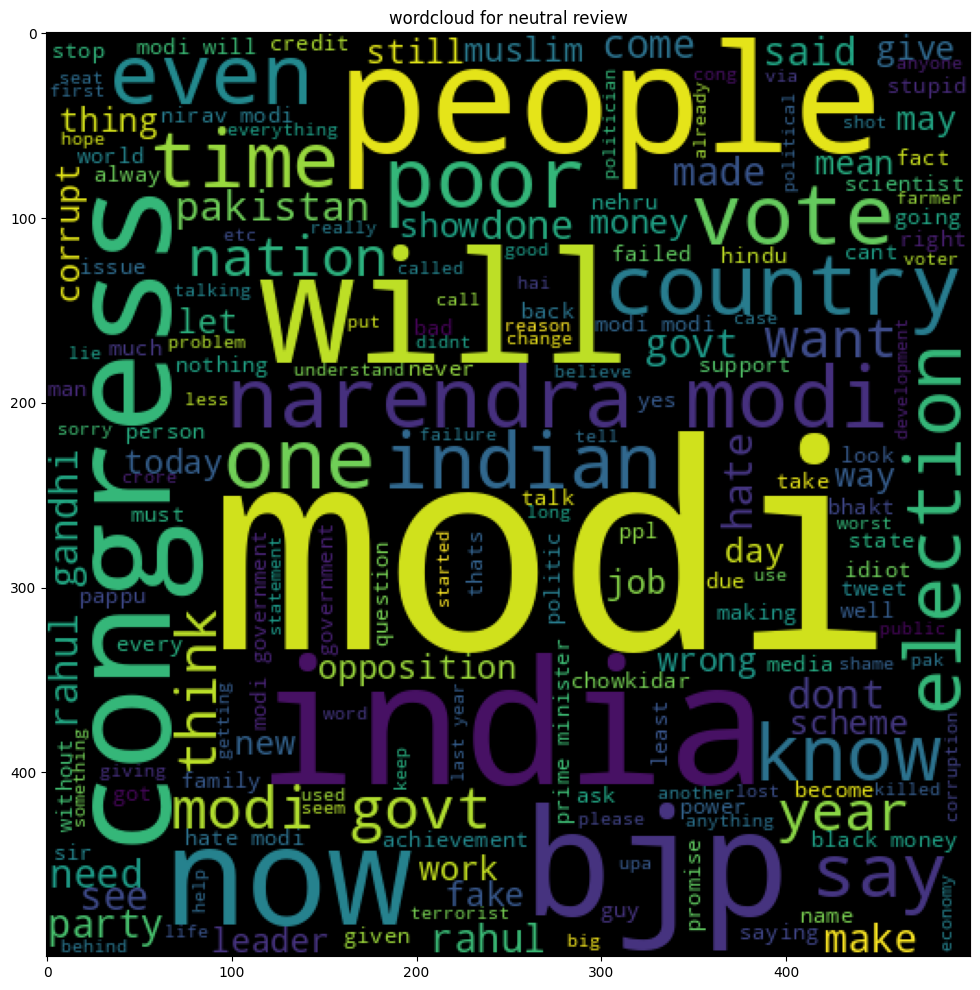

In [33]:
plt.figure(figsize = (12, 12))
plt.title('wordcloud for neutral review')
plt.imshow(neutral_wc)

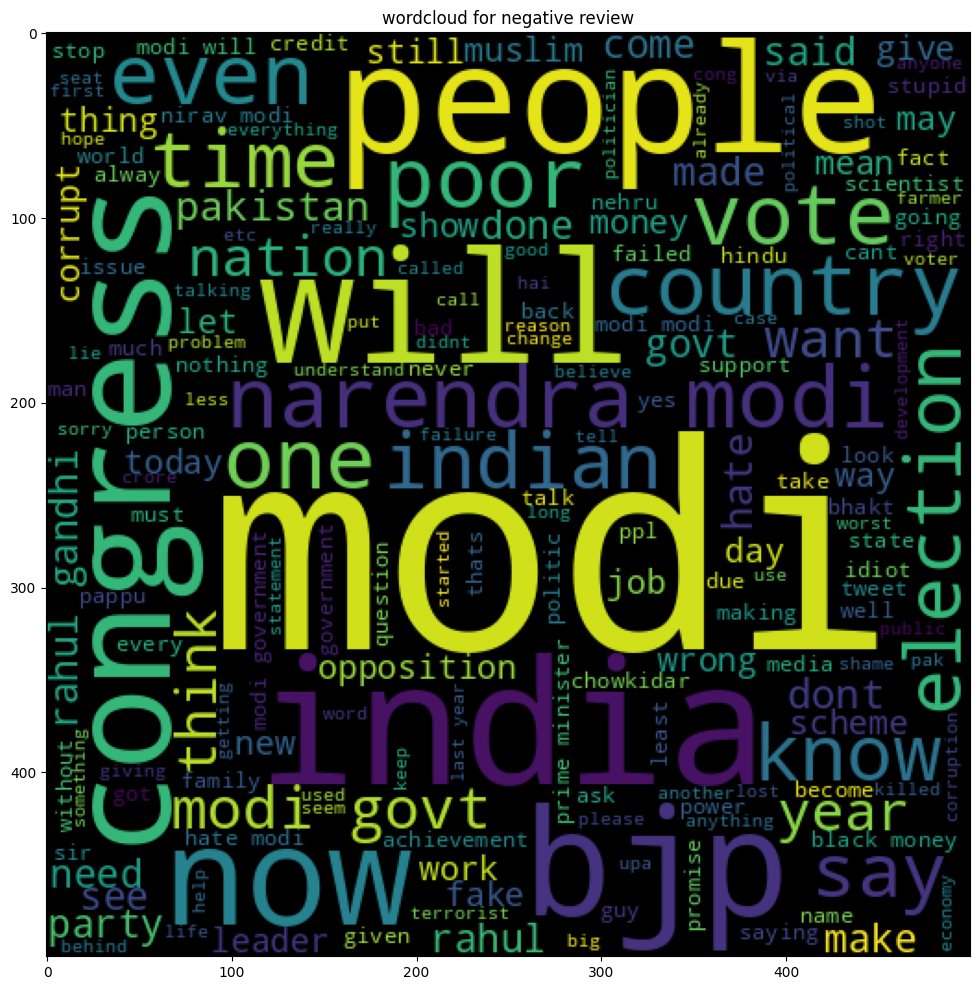

In [34]:
plt.figure(figsize = (12, 12))
plt.title('wordcloud for negative review')
plt.imshow(negative_wc)



In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,  ConfusionMatrixDisplay

In [37]:
X = twitter_data['clean_text'].values.astype('U')
y = twitter_data['category'].values.astype('U')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [39]:
pipe = Pipeline([('tfidf_vectorizer',TfidfVectorizer(lowercase = True, stop_words = 'english',analyzer = 'word')), ('naive_bayes', MultinomialNB())])
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

pipe.fit(list(X_train), list(y_train))
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred, y_test))
pipe['naive_bayes']

[[ 1358    55    62     0]
 [  398  5662   535     0]
 [ 8897 10847 21078     2]
 [    0     0     0     0]]
0.5746717388636643


MultinomialNB()

In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [51]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to have consistent length
X_padded = pad_sequences(X_sequences)

# Split the data into training and testing sets
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_padded, labels, test_size=0.3, stratify=labels)


In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_padded.shape[1]),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes: negative, neutral, positive
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [53]:
model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
1427/1427 [==============================] - 319s 222ms/step - loss: 0.3203 - accuracy: 0.8829 - val_loss: 0.1537 - val_accuracy: 0.9550
Epoch 2/5
1427/1427 [==============================] - 316s 221ms/step - loss: 0.1000 - accuracy: 0.9699 - val_loss: 0.1167 - val_accuracy: 0.9642
Epoch 3/5
1427/1427 [==============================] - 314s 220ms/step - loss: 0.0532 - accuracy: 0.9830 - val_loss: 0.1251 - val_accuracy: 0.9636
Epoch 4/5
1427/1427 [==============================] - 317s 222ms/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.1272 - val_accuracy: 0.9666
Epoch 5/5
1427/1427 [==============================] - 315s 221ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.1480 - val_accuracy: 0.9642


In [54]:
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


1528/1528 [==============================] - 18s 12ms/step - loss: 0.1422 - accuracy: 0.9645
Test Loss: 0.142240509390831, Test Accuracy: 0.9645150899887085


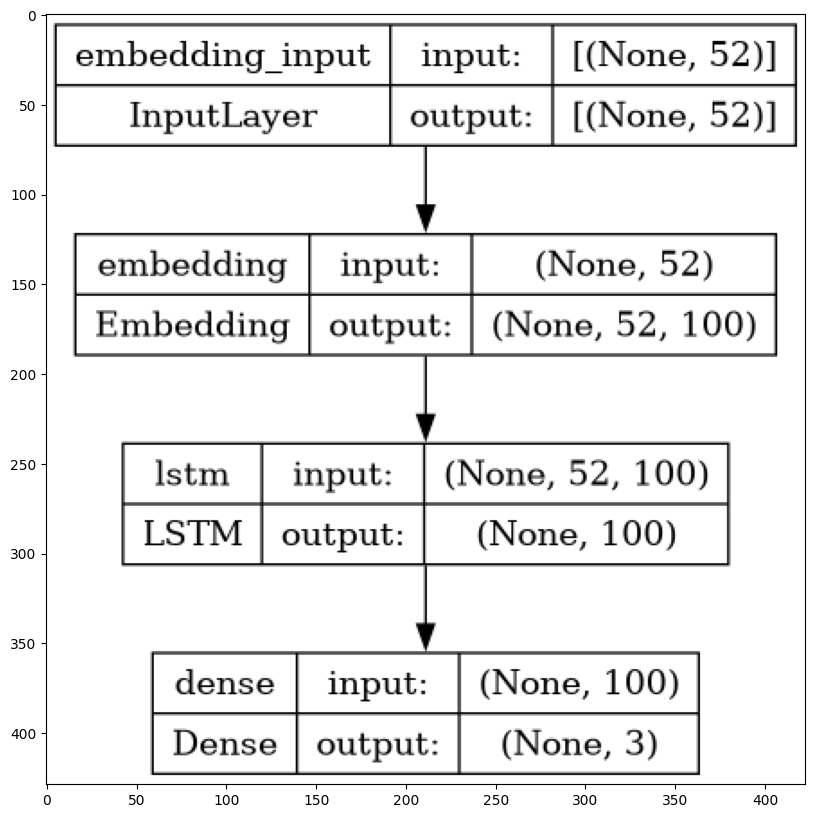

In [56]:
from tensorflow.keras.utils import plot_model
# Assuming 'model' is your Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()